In [1]:
from functools import partial
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
import jax
import optax
import flax
from flax.training import train_state, checkpoints

print(f"JAX devices:{jax.devices()}")

from dataset.chirping_binary import ChirpingBinary
from models.signalprocessing import SaShiMi, Mamba
import training

JAX devices:[cuda(id=0)]


In [2]:
rng_key = jax.random.key(0)
batch_size = 128


sample_rate_Hz = 1000.0
episode_duration_s = 2**10 / sample_rate_Hz
print(f"{episode_duration_s=}, {sample_rate_Hz=}, nsamples={episode_duration_s*sample_rate_Hz}")
dataset = ChirpingBinary(1, episode_duration_s, sample_rate_Hz, scale=1e20)
model = Mamba(stages=3, stage_layers=3, hidden_state_dim=16)
print(model.tabulate(rng_key, dataset.sample(rng_key)[0], depth=1))

episode_duration_s=1.024, sample_rate_Hz=1000.0, nsamples=1024.0

                                 Mamba Summary                                  
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┓
┃ path         ┃ module     ┃ inputs         ┃ outputs        ┃ params         ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━┩
│              │ Mamba      │ float32[1024,… │ float32[1024,… │                │
├──────────────┼────────────┼────────────────┼────────────────┼────────────────┤
│ DownPool_0   │ DownPool   │ float32[1024,… │ float32[256,4] │ 36 (144 B)     │
├──────────────┼────────────┼────────────────┼────────────────┼────────────────┤
│ DownPool_1   │ DownPool   │ float32[256,4] │ float32[64,8]  │ 136 (544 B)    │
├──────────────┼────────────┼────────────────┼────────────────┼────────────────┤
│ MambaBlock_0 │ MambaBlock │ float32[64,8]  │ float32[64,8]  │ 5,081 (21.4    │
│              │            │              

In [3]:
optimization_step = jax.jit(partial(training.optimization_step, loss_fn=training.signal_mse_loss))
get_batch = jax.jit(dataset.get_batch, static_argnames=["batch_size"])


state = train_state.TrainState.create(
    apply_fn=model.apply,
    params=model.init(rng_key, dataset.sample(rng_key)[0]),
    tx=optax.chain(optax.clip(1.0), optax.adam(1e-3, b2=0.95)),
)

In [4]:
N_epochs = 10
batches_per_epoch = 1000

for epoch_idx, epoch_rng_key in enumerate(tqdm(jax.random.split(rng_key, N_epochs))):
    losses = []
    for batch_rng_key in tqdm(jax.random.split(epoch_rng_key, batches_per_epoch), leave=False):
        x, y = get_batch(batch_rng_key, batch_size)
        state, loss_value = optimization_step(state, x, y)
        losses.append(loss_value)

    #checkpoints.save_checkpoint(ckpt_dir="/tmp/checkpoints", target=train_state, step=epoch_idx)
    print(f"Loss: {sum(losses) / len(losses)}")

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

/home/davide_sartor/.local/lib/python3.10/site-packages/jax/_src/lax/lax.py:2660: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


Loss: 0.6957818865776062


  0%|          | 0/1000 [00:00<?, ?it/s]

Loss: 0.20223109424114227


  0%|          | 0/1000 [00:00<?, ?it/s]

Loss: 0.15049870312213898


  0%|          | 0/1000 [00:00<?, ?it/s]

Loss: 0.1258302479982376


  0%|          | 0/1000 [00:00<?, ?it/s]

Loss: 0.1141195297241211


  0%|          | 0/1000 [00:00<?, ?it/s]

Loss: 0.1087733581662178


  0%|          | 0/1000 [00:00<?, ?it/s]

Loss: 0.10759304463863373


  0%|          | 0/1000 [00:00<?, ?it/s]

Loss: 0.10122180730104446


  0%|          | 0/1000 [00:00<?, ?it/s]

Loss: 0.09700287133455276


  0%|          | 0/1000 [00:00<?, ?it/s]

Loss: 0.09366295486688614


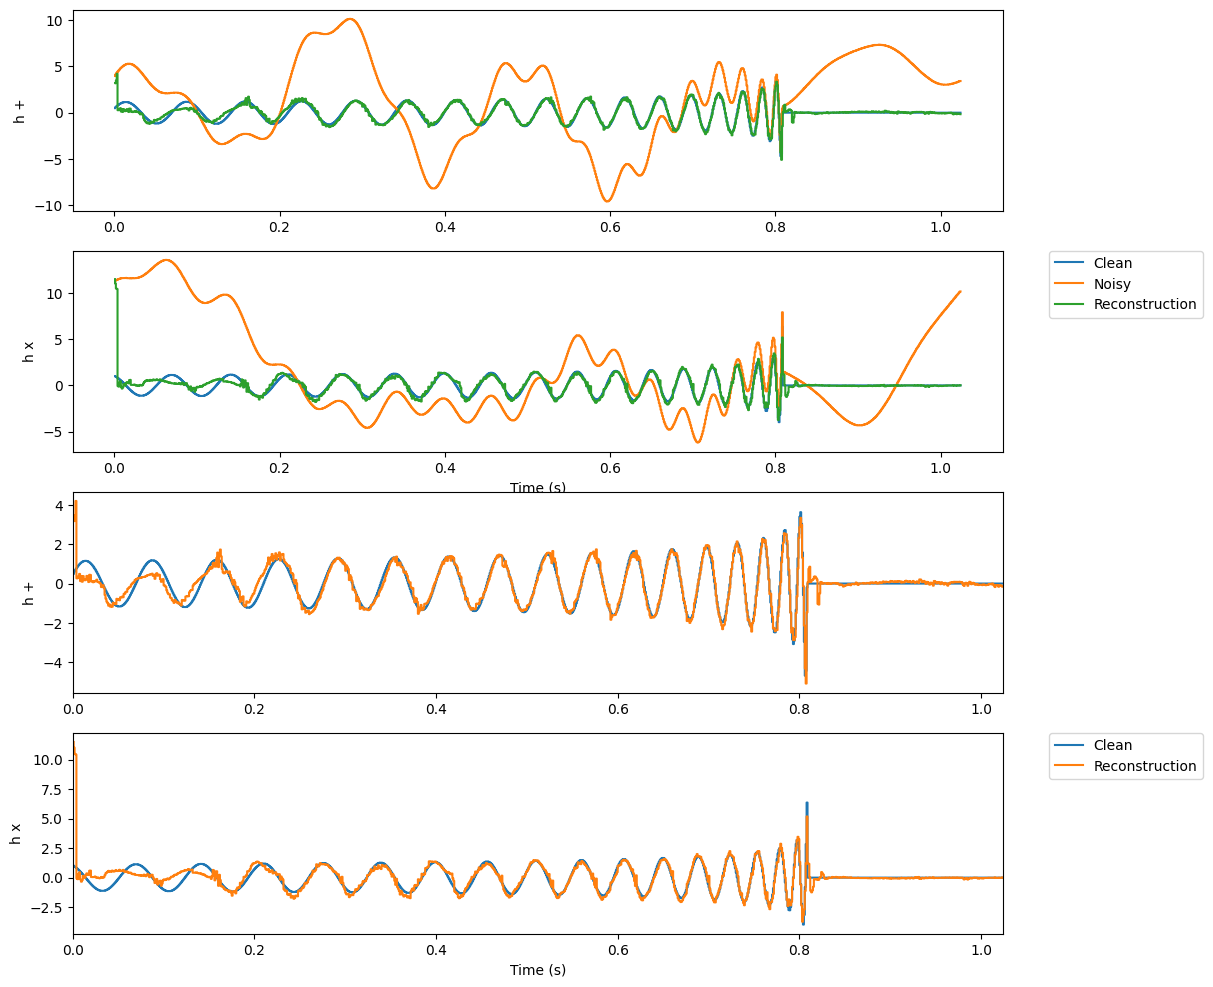

In [5]:
rng_key, subkey = jax.random.split(rng_key) 
x, y = get_batch(subkey, batch_size)
out = state.apply_fn(state.params, x[0])
plt.figure(figsize=(12, 12))
plt.subplot(4, 1, 1)
plt.step(dataset.times, y[0][:, 0], label="Clean")
plt.step(dataset.times, x[0][:, 0], label="Noisy")
plt.step(dataset.times, out[:, 0], label="Reconstruction")
plt.ylabel("h +")
plt.subplot(4, 1, 2)
plt.step(dataset.times, y[0][:, 1], label="Clean")
plt.step(dataset.times, x[0][:, 1], label="Noisy")
plt.step(dataset.times, out[:, 1], label="Reconstruction")
plt.ylabel("h x")
plt.xlabel("Time (s)")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
plt.subplot(4, 1, 3)
plt.step(dataset.times, y[0][:, 0], label="Clean")
plt.step(dataset.times, out[:, 0], label="Reconstruction")
plt.xlim(dataset.episode_duration_s // 2, dataset.episode_duration_s)
plt.ylabel("h +")
plt.subplot(4, 1, 4)
plt.step(dataset.times, y[0][:, 1], label="Clean")
plt.step(dataset.times, out[:, 1], label="Reconstruction")
plt.xlim(dataset.episode_duration_s // 2, dataset.episode_duration_s)
plt.ylabel("h x")
plt.xlabel("Time (s)")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
plt.show()